In [ ]:
!pip install tensorflow==2.10.0
!pip install torch==1.12.1
!pip install transformers==4.20.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempti

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 771.0 kB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._deter

In [ ]:
import pandas as pd

# Reading the csv file
df = pd.read_csv('RansomwareData.csv')


In [ ]:
X = df.drop([df.columns[0], df.columns[1], df.columns[2]], axis=1).values
y = df[df.columns[2]]

y_binary = df[df.columns[1]].values

# Create group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

y_group = y.apply(convert_to_group).values
y_specific = df[df.columns[2]].values

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.models import Model

# Define a simplified transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the simplified model
def create_simplified_model(input_shape):
    inputs = Input(shape=input_shape)
    dense_reduced = Dense(64, activation="relu")(inputs)
    dense_reduced = tf.expand_dims(dense_reduced, axis=1)  # Add sequence dimension

    transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=64)
    x = transformer_block(dense_reduced)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)  # Pooling to reduce sequence dimension
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)

    # Classification heads
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
    group_output = Dense(5, activation='softmax', name='group_output')(x)
    specific_output = Dense(12, activation='softmax', name='specific_output')(x)

    model = Model(inputs=inputs, outputs=[binary_output, group_output, specific_output])
    return model

# Create and compile the model
model = create_simplified_model((30967,))
model.compile(optimizer='adam',
              loss={'binary_output': 'binary_crossentropy', 'group_output': 'sparse_categorical_crossentropy', 'specific_output': 'sparse_categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'group_output': 'accuracy', 'specific_output': 'accuracy'})

# Print the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 30967)]      0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 64)           1981952     ['input_7[0][0]']                
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 1, 64)        0           ['dense_15[0][0]']               
                                                                                                  
 transformer_block_5 (Transform  (None, 1, 64)       74944       ['tf.expand_dims_2[0][0]']       
 erBlock)                                                                                   

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_binary, y_test_binary, y_train_group, y_test_group = train_test_split(X, y, y_binary, y_group, test_size=0.2, random_state=42)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train,
                    {'binary_output': y_train_binary, 'group_output': y_train_group, 'specific_output': y_train},
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/50
31/31 [==============================] - 7s 85ms/step - loss: 2.5461 - binary_output_loss: 0.3464 - group_output_loss: 0.8829 - specific_output_loss: 1.3168 - binary_output_accuracy: 0.8511 - group_output_accuracy: 0.6632 - specific_output_accuracy: 0.6150 - val_loss: 1.7020 - val_binary_output_loss: 0.1796 - val_group_output_loss: 0.5588 - val_specific_output_loss: 0.9636 - val_binary_output_accuracy: 0.9262 - val_group_output_accuracy: 0.8074 - val_specific_output_accuracy: 0.7377
Epoch 2/50
31/31 [==============================] - 1s 29ms/step - loss: 1.3288 - binary_output_loss: 0.1143 - group_output_loss: 0.4618 - specific_output_loss: 0.7527 - binary_output_accuracy: 0.9630 - group_output_accuracy: 0.8347 - specific_output_accuracy: 0.7813 - val_loss: 1.1766 - val_binary_output_loss: 0.0866 - val_group_output_loss: 0.3967 - val_specific_output_loss: 0.6933 - val_binary_output_accuracy: 0.9754 - val_group_output_accuracy: 0.8443 - val_specific_output_accuracy: 0.7828
Ep

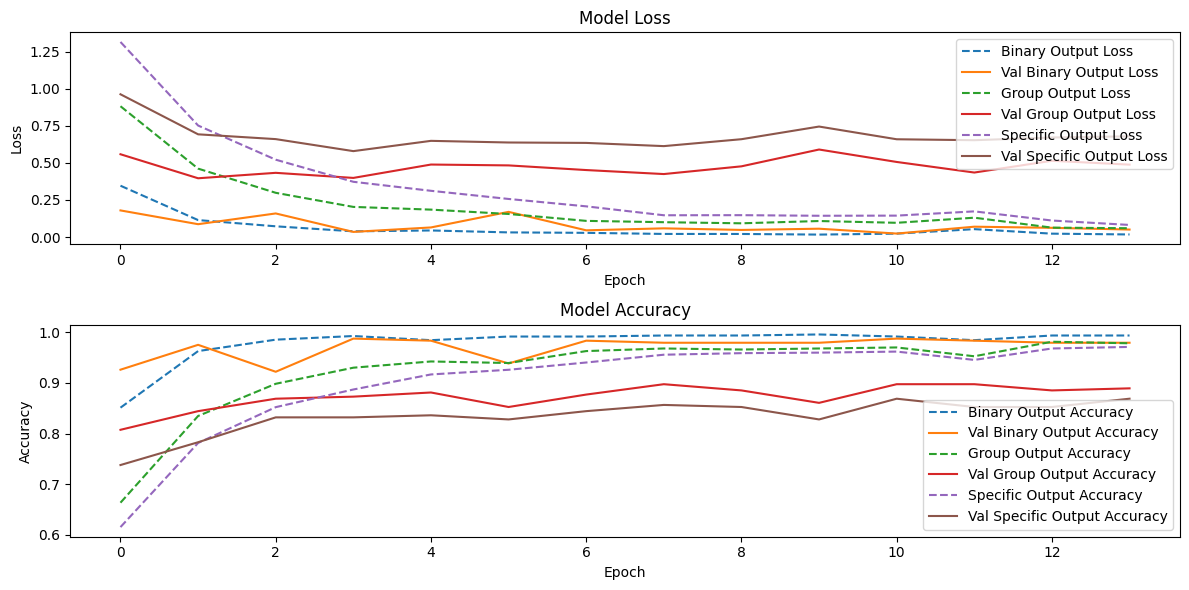

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(history.history['binary_output_loss'], linestyle='--', label='Binary Output Loss')
plt.plot(history.history['val_binary_output_loss'], label='Val Binary Output Loss')
plt.plot(history.history['group_output_loss'], linestyle='--', label='Group Output Loss')
plt.plot(history.history['val_group_output_loss'], label='Val Group Output Loss')
plt.plot(history.history['specific_output_loss'], linestyle='--', label='Specific Output Loss')
plt.plot(history.history['val_specific_output_loss'], label='Val Specific Output Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 1, 2)
plt.plot(history.history['binary_output_accuracy'], linestyle='--', label='Binary Output Accuracy')
plt.plot(history.history['val_binary_output_accuracy'], label='Val Binary Output Accuracy')
plt.plot(history.history['group_output_accuracy'], linestyle='--', label='Group Output Accuracy')
plt.plot(history.history['val_group_output_accuracy'], label='Val Group Output Accuracy')
plt.plot(history.history['specific_output_accuracy'], linestyle='--', label='Specific Output Accuracy')
plt.plot(history.history['val_specific_output_accuracy'], label='Val Specific Output Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


10/10 [==============================] - 0s 19ms/step


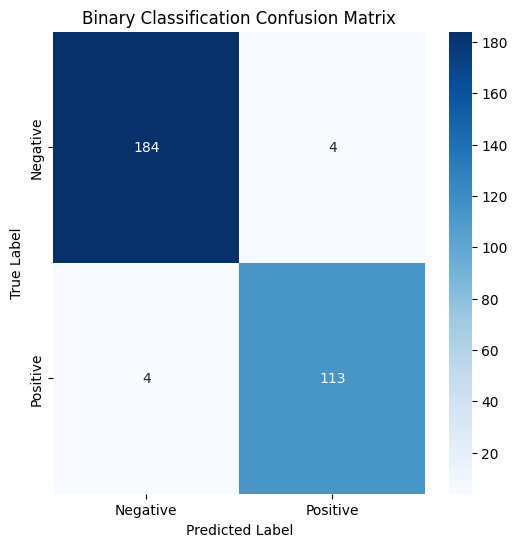

10/10 [==============================] - 0s 17ms/step


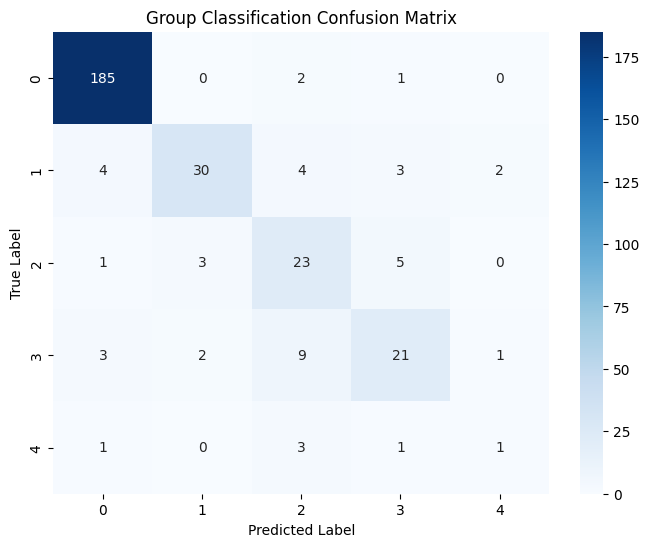

10/10 [==============================] - 0s 17ms/step


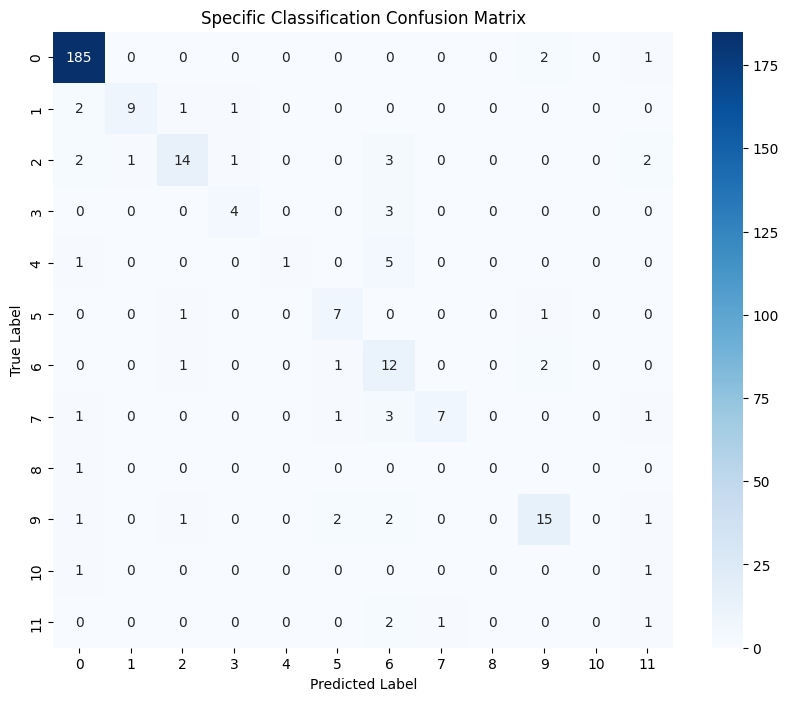

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Get predictions for binary classification head
y_binary_pred = model.predict(X_test)[0]
y_binary_pred_classes = (y_binary_pred > 0.5).astype("int32")


cm_binary = confusion_matrix(y_test_binary, y_binary_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Binary Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get predictions for group classification head
y_group_pred = model.predict(X_test)[1]
y_group_pred_classes = y_group_pred.argmax(axis=1)

# Compute confusion matrix
cm_group = confusion_matrix(y_test_group, y_group_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_group, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.title('Group Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Get predictions for specific classification head
y_specific_pred = model.predict(X_test)[2]
y_specific_pred_classes = y_specific_pred.argmax(axis=1)

# Compute confusion matrix
cm_specific = confusion_matrix(y_test, y_specific_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_specific, annot=True, fmt="d", cmap="Blues", xticklabels=range(12), yticklabels=range(12))
plt.title('Specific Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
